In [ ]:
!pip install pandas
!pip install networkx
!pip install imageio

In [ ]:
!pip install pygraphviz

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.0/106.0 kB 3.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for pygraphviz
Failed to build pygraphviz
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (pygraphviz)


In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import pandas as pd
import numpy as np

## Permodelan Markov Chain dalam Generasi Teks

Rantai Markov adalah model matematika yang digunakan untuk menyimulasikan proses acak yang terjadi selama periode waktu tertentu. Model ini terdiri dari sejumlah keadaan (state) dan transisi antar keadaan tersebut. Transisi ini bersifat probabilistik, yang berarti bahwa kemungkinan berpindah dari satu keadaan ke keadaan lainnya hanya bergantung pada keadaan saat ini, dan tidak bergantung pada kejadian di masa lalu. Model ini memiliki berbagai aplikasi dalam bidang seperti fisika, kimia, biologi, ekonomi, dan ilmu komputer.

* Matriks Transisi: Konsep matematika utama dalam rantai Markov adalah matriks transisi. Ini adalah matriks persegi yang menggambarkan probabilitas berpindah dari satu keadaan ke keadaan lainnya. Jika terdapat n keadaan dalam rantai Markov, maka matriks transisinya akan berukuran n x n, di mana setiap elemen (i, j) pada matriks tersebut mewakili probabilitas berpindah dari keadaan i ke keadaan j. Jumlah dari setiap baris dalam matriks transisi harus sama dengan 1, karena total probabilitas berpindah ke setiap keadaan dari keadaan saat ini harus berjumlah 1.
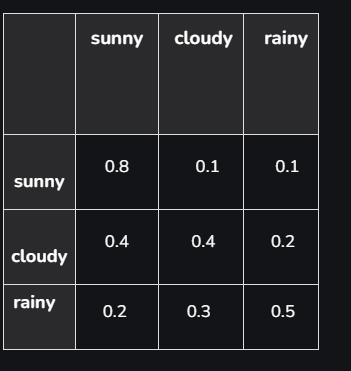

* Persamaan Chapman-Kolmogorov: Teorema dasar dari teori rantai Markov adalah persamaan Chapman-Kolmogorov. Persamaan ini menyatakan bahwa probabilitas berpindah dari satu keadaan ke keadaan lainnya dalam beberapa langkah adalah hasil perkalian dari probabilitas transisi untuk setiap langkah tersebut. Artinya, kita dapat menghitung probabilitas dari rangkaian transisi tertentu dengan mengalikan probabilitas dari masing-masing transisi individu.
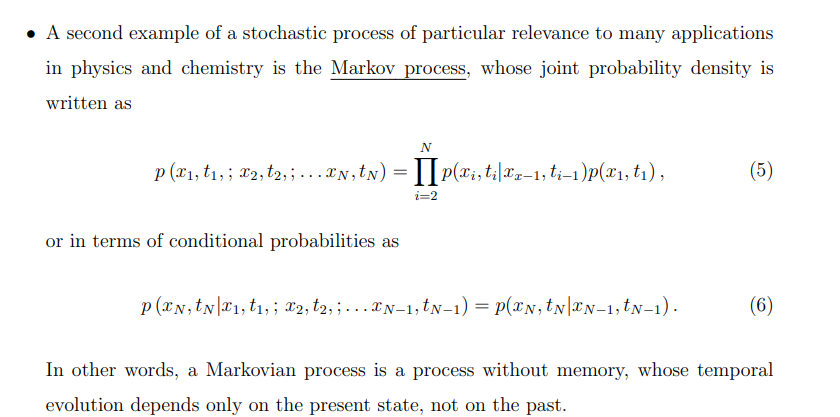


### Bagaimana kita memodelkan generasi teksnya? 🤔

Misalkan kita mempunyai sebuah string $S$ yang berisikan kumpulan kata yaitu $W_i$ untuk ($ 1 \leq i \leq len(S) $). Ada banyak sekali metode dalam tokenisasi tapi yang umumnya dilakukan adalah dengan mengambil sebuah $n-gram$ dari kalimat tersebut.

$n-gram$ artinya kita akan memecah kalimat menjadi sub-kalimat berukuran n.

Sebagai contoh
`aku sayang kamu loh` untuk bi-gram (n-gram berukuran 2) artinya kita akan memecah menjadi sub kalimat berukuran 2 menjadi
bigram pertama yaitu : `aku sayang`
dan bigram kedua yaitu `kamu loh`

In [ ]:
def createWordGram(size: int, sentence: str):
    words = sentence.split()
    if size <= 0:
        return []
    return [tuple(words[i:i + size]) for i in range(len(words) - size + 1)]

In [ ]:
createWordGram(2, "aku sayang kamu loh")

[('aku', 'sayang'), ('sayang', 'kamu'), ('kamu', 'loh')]

In [ ]:
text = "the very quick brown fox jumps over the lazy dog"
n_grams = createWordGram(2,text)

Dari n-gram ini, kita dapat membangun matriks transisi yang merepresentasikan probabilitas perpindahan dari satu kata ke kata berikutnya. Probabilitas ini dihitung dengan menghitung seberapa sering sebuah kata muncul setelah kata lainnya dalam n-gram yang terbentuk.

In [ ]:
def transitionMatrix(text,size_n_gram):
  n_grams = createWordGram(size_n_gram,text)
    # Mengambil kata unik dari teks
  unique_words = list(set(text.split()))

  # Membuat matriks transisi
  transition_matrix = np.zeros((len(unique_words), len(unique_words)))

  # Mengisi matriks transisi berdasarkan bi-gram
  for i, word in enumerate(unique_words):
      for j, next_word in enumerate(unique_words):
          count = 0
          for n_gram in n_grams:
              if n_gram[0] == word and n_gram[1] == next_word:
                  count += 1
          transition_matrix[i, j] = count

  # Mengonversi matriks transisi ke DataFrame dengan label kolom dan baris
  transition_df = pd.DataFrame(transition_matrix, index=unique_words, columns=unique_words)
  return transition_df

In [ ]:
tMatrix = transitionMatrix(text,2)
tMatrix

,jumps,brown,the,quick,fox,dog,lazy,very,over
jumps,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
brown,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
the,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
quick,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fox,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lazy,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
very,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
over,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
import pandas as pd
import numpy as np

def normalizeTransitionMatrix(matrix):
    row_sums = matrix.sum(axis=1)

    row_sums[row_sums == 0] = 1
    normalized_matrix = matrix.div(row_sums, axis=0)

    return normalized_matrix


In [ ]:
# Normalize transition matrix
normalizedTMatrix = normalizeTransitionMatrix(tMatrix)
normalizedTMatrix

,jumps,brown,the,quick,fox,dog,lazy,very,over
jumps,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
brown,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
the,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.5,0.0
quick,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fox,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dog,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
lazy,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
very,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
over,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Notes : Penggunaan huruf kapital sangat berpengaruh, nantinya kita bisa mengidentifikasi kedudukan kata berdasarkan kata sebelumnya bertipekan huruf kapital atau bukan.

Sebagai contoh <br />
`The building is big` <br />
`The Big Building`

kita bisa identifikasi bahwa `Big` pada `Big Building` merupakan kata ganti serta bagian dari subjek dan `big` merupakan kata sifat.

Namun masalah ini belum bisa dikembangkan, untuk handling ini pada proses tokenisasi semua kata akan di-lower case, karena kita masih berfokus pada permodelan markov secara sederhana terlebih dahulu.

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

def plotMarkovChain(transition_matrix):
    """
    Fungsi untuk menggambarkan graf Markov Chain dari matriks transisi.

    Parameters:
    transition_matrix (pd.DataFrame): Matriks transisi dalam bentuk DataFrame.
    """
    # Membuat graf kosong
    G = nx.DiGraph()

    # Menambahkan node dan edge dari matriks transisi
    for i, row in transition_matrix.iterrows():
        for j, value in row.items():
            if value > 0:  # Menambahkan edge hanya jika ada transisi (probabilitas > 0)
                G.add_edge(i, j, weight=value)

    # Posisi node menggunakan layout spring untuk visualisasi yang lebih baik
    pos = nx.spring_layout(G, seed=42)

    # Menggambar graf
    plt.figure(figsize=(10, 8))

    # Menambahkan node dan edge
    nx.draw_networkx_nodes(G, pos, node_size=3000, node_color="skyblue")
    nx.draw_networkx_edges(G, pos, edgelist=G.edges(), edge_color="gray", width=2)
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    # Menampilkan bobot dari setiap edge (probabilitas transisi)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)

    # Menampilkan graf
    plt.title("Markov Chain Transition Graph")
    plt.axis("off")
    plt.show()

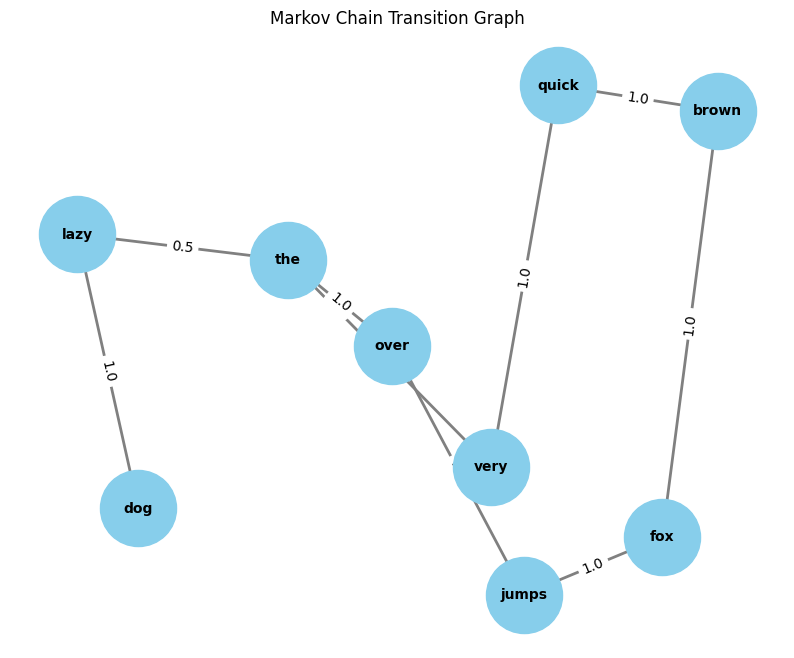

In [ ]:
plotMarkovChain(normalizedTMatrix)

### Permodelan Generasi Teks dengan Parameter jumlah state = jumlah kata yang ingin dihasilkan

### Properti Markov Chain
Karakteristik utama dari Rantai Markov adalah properti Markov (Markov Property), yang menyatakan bahwa prediksi kejadian masa depan hanya bergantung pada keadaan saat ini, bukan pada rangkaian kejadian sebelumnya. Secara formal, ini dapat dinyatakan sebagai:
$P(Xₙ₊₁ = x | X₁ = x₁, X₂ = x₂, ..., Xₙ = xₙ) = P(Xₙ₊₁ = x | Xₙ = xₙ)$
di mana:

$Xₙ$ adalah keadaan sistem pada waktu n
$P$ adalah probabilitas transisi

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from IPython.display import Image

def plotMarkovChainGif(transition_df, start_word, N_steps=100, gif_filename='markov_chain.gif'):
    """
    Create an animated GIF of a Markov chain simulation using pandas DataFrame transition matrix.
    Handles NaN values in transition probabilities.

    Parameters:
    -----------
    transition_df : pandas.DataFrame
        Transition matrix as a DataFrame where indices and columns are words
    start_word : str
        Initial state of the Markov chain
    N_steps : int
        Number of steps to simulate
    gif_filename : str
        Output filename for the GIF
    """
    # Create directed graph from transition matrix
    G = nx.DiGraph()

    # Add edges with weights from DataFrame
    for source in transition_df.index:
        for target in transition_df.columns:
            weight = transition_df.loc[source, target]
            if weight > 0 and not np.isnan(weight):  # Only add edges with valid non-zero probability
                G.add_edge(source, target, weight=weight)

    # Set up the figure
    fig, ax = plt.subplots(figsize=(12, 8))

    # Calculate layout once and reuse it
    pos = nx.spring_layout(G, k=1, iterations=50)

    # Get node colors
    node_colors = ['lightblue' for _ in G.nodes()]
    edge_colors = ['gray' for _ in G.edges()]

    def get_next_state(current_state):
        """Helper function to get next state based on transition probabilities"""
        probabilities = transition_df.loc[current_state].values
        next_states = transition_df.columns.values

        # Replace NaN with 0
        probabilities = np.nan_to_num(probabilities, 0)

        # If all probabilities are 0, randomly choose next state
        if np.sum(probabilities) == 0:
            return np.random.choice(next_states)

        # Normalize probabilities
        probabilities = probabilities / np.sum(probabilities)

        return np.random.choice(next_states, p=probabilities)

    # Function to update frame
    def update(frame):
        ax.clear()

        # Reset colors
        current_node_colors = node_colors.copy()
        current_edge_colors = edge_colors.copy()

        # Calculate current state
        current_state = start_word
        path = [current_state]

        for _ in range(frame):
            next_state = get_next_state(current_state)
            path.append(next_state)
            current_state = next_state

        # Highlight current node and previous edge
        if current_state in G.nodes():
            current_node_colors[list(G.nodes()).index(current_state)] = 'red'

        if len(path) > 1:
            try:
                edge_idx = list(G.edges()).index((path[-2], path[-1]))
                current_edge_colors[edge_idx] = 'red'
            except ValueError:
                pass  # Edge might not exist due to zero probability

        # Draw the graph
        nx.draw_networkx_nodes(G, pos, node_color=current_node_colors,
                             node_size=1000, ax=ax)
        nx.draw_networkx_edges(G, pos, edge_color=current_edge_colors,
                             width=2, ax=ax, arrowsize=20)
        nx.draw_networkx_labels(G, pos, ax=ax)

        # Add edge labels
        edge_labels = nx.get_edge_attributes(G, 'weight')
        edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, ax=ax)

        ax.set_title(f'Step {frame}')
        ax.axis('off')

    # Create animation
    anim = FuncAnimation(
        fig, update, frames=N_steps,
        interval=500, repeat=True
    )

    # Save as GIF
    writer = PillowWriter(fps=1)
    anim.save(gif_filename, writer=writer)
    plt.close()

    # Display the GIF
    return Image(filename=gif_filename)

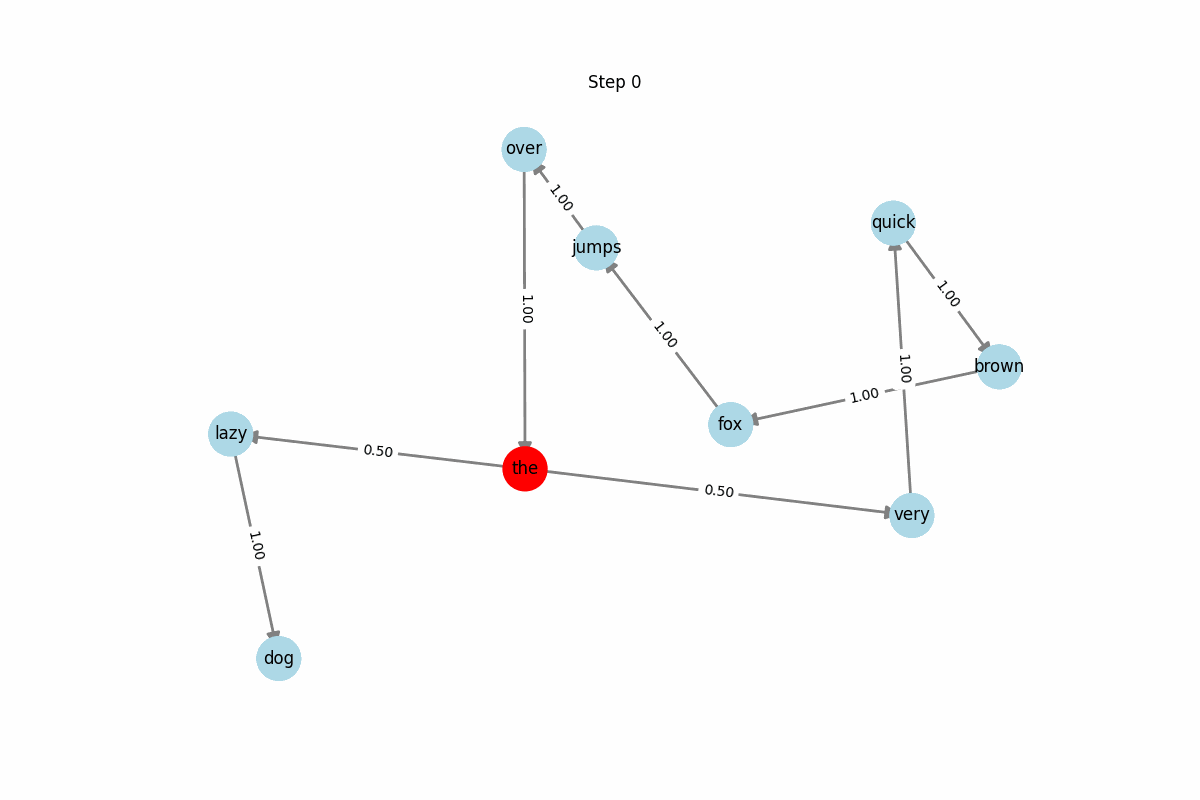

In [ ]:
plotMarkovChainGif(normalizedTMatrix,"the",N_steps=10, gif_filename='markov_chain_simulation2.gif')

Formula Distribusi Peluang
Distribusi peluang untuk Rantai Markov dapat dihitung menggunakan formula berikut:

Distribusi keadaan pada waktu $n$:
$π(n) = π(0)P^n$
di mana:

$π(n)$ adalah vektor distribusi peluang pada waktu n
$π(0)$ adalah distribusi awal
$P^n$ adalah matriks transisi dipangkatkan n


Probabilitas transisi n-langkah:
$pᵢⱼ(n) = P(Xₙ = j | X₀ = i)$
Element ke-$(i,j)$ dari matriks $P^n$
Distribusi stasioner (jika ada):
$π = πP$
di mana $π$ adalah vektor distribusi stasioner yang memenuhi:
$Σᵢ πᵢ = 1$ dan $πᵢ ≥ 0$ untuk semua $i$

In [ ]:
import numpy as np
import pandas as pd
from typing import Union, List, Tuple, Dict, Optional
import networkx as nx
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from collections import defaultdict, deque

class MarkovTextGenerator:
    def __init__(self, transition_matrix: Optional[pd.DataFrame] = None):
        """
        Initialize the Markov Chain text generator.

        Parameters:
        -----------
        transition_matrix : Optional[pd.DataFrame]
            Pre-computed normalized transition matrix where indices and columns are words.
            If None, the model needs to be built from tokens using build_model().
        """
        self.transition_matrix = transition_matrix
        self.generation_history = []
        self.word_counts = defaultdict(lambda: defaultdict(int))
        self.vocabulary = set(transition_matrix.index) if transition_matrix is not None else set()

        # Validate transition matrix if provided
        if transition_matrix is not None:
            self._validate_transition_matrix(transition_matrix)

    def _validate_transition_matrix(self, matrix: pd.DataFrame) -> None:
        """
        Validate the transition matrix format and properties.

        Parameters:
        -----------
        matrix : pd.DataFrame
            Transition matrix to validate

        Raises:
        -------
        ValueError
            If matrix format is invalid or probabilities are not normalized
        """
        # Check if matrix is square
        if matrix.shape[0] != matrix.shape[1]:
            raise ValueError("Transition matrix must be square")

        # Check if indices and columns match
        if not all(matrix.index == matrix.columns):
            raise ValueError("Matrix indices and columns must match")

        # Check if probabilities are normalized (sum to 1 or 0 for each row)
        row_sums = matrix.sum(axis=1)
        if not all((abs(s - 1.0) < 1e-10) or (abs(s) < 1e-10) for s in row_sums):
            raise ValueError("Matrix rows must sum to 1 (or 0 for absorbing states)")

        # Check for negative probabilities
        if (matrix.values < 0).any():
            raise ValueError("Matrix cannot contain negative probabilities")

    def tokenize(self, text: Union[str, List[str]]) -> List[str]:
        """Tokenize and clean text."""
        if isinstance(text, str):
            text = [text]

        cleaned_tokens = []
        for line in text:
            line = line.lower()
            line = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-\\]", "", line)
            tokens = word_tokenize(line)
            words = [word for word in tokens if word.isalpha()]
            cleaned_tokens.extend(words)

        return cleaned_tokens

    def build_model(self, tokens: List[str]) -> None:
        """
        Build the transition matrix from tokens.

        Parameters:
        -----------
        tokens : List[str]
            List of tokens to build the model from
        """
        # Reset existing model
        self.word_counts = defaultdict(lambda: defaultdict(int))
        self.vocabulary = set()

        # Count transitions
        for i in range(len(tokens) - 1):
            current_word = tokens[i]
            next_word = tokens[i + 1]
            self.word_counts[current_word][next_word] += 1
            self.vocabulary.add(current_word)
            self.vocabulary.add(next_word)

        # Create transition matrix
        vocab_list = sorted(list(self.vocabulary))
        matrix_data = np.zeros((len(vocab_list), len(vocab_list)))

        for i, current_word in enumerate(vocab_list):
            total_count = sum(self.word_counts[current_word].values())
            if total_count > 0:
                for j, next_word in enumerate(vocab_list):
                    count = self.word_counts[current_word][next_word]
                    matrix_data[i][j] = count / total_count

        self.transition_matrix = pd.DataFrame(
            matrix_data,
            index=vocab_list,
            columns=vocab_list
        )

    def set_transition_matrix(self, matrix: pd.DataFrame) -> None:
        """
        Set a new transition matrix for the model.

        Parameters:
        -----------
        matrix : pd.DataFrame
            New normalized transition matrix
        """
        self._validate_transition_matrix(matrix)
        self.transition_matrix = matrix
        self.vocabulary = set(matrix.index)
        self.word_counts = defaultdict(lambda: defaultdict(int))  # Reset word counts
        self.generation_history = []  # Reset generation history

    def get_vocabulary(self) -> set:
        """Return the model's vocabulary"""
        return self.vocabulary

    def get_word_counts(self) -> Dict:
        """Return the raw word transition counts"""
        return self.word_counts

    def get_transition_matrix(self) -> pd.DataFrame:
        """Return the transition matrix"""
        return self.transition_matrix

    def _select_next_word_random(self, probs: np.ndarray, words: np.ndarray) -> str:
        """Standard random sampling based on probabilities"""
        return np.random.choice(words, p=probs/np.sum(probs))

    def _select_next_word_maximum(self, probs: np.ndarray, words: np.ndarray) -> str:
        """Choose from highest probability states"""
        max_prob = np.max(probs)
        max_indices = np.where(probs == max_prob)[0]
        chosen_index = np.random.choice(max_indices)
        return words[chosen_index]

    def _select_next_word_weighted(self, probs: np.ndarray, words: np.ndarray, temp: float) -> str:
        """Temperature-adjusted random sampling"""
        scaled_probs = np.power(probs, 1/temp)
        scaled_probs = scaled_probs / np.sum(scaled_probs)
        return np.random.choice(words, p=scaled_probs)

    def _select_next_word_combined(self, probs: np.ndarray, words: np.ndarray,
                                 methods_weights: List[Tuple[str, float]], temperature: float) -> str:
        """Apply multiple methods with given weights"""
        method_names, weights = zip(*methods_weights)
        chosen_method = np.random.choice(method_names, p=weights)

        if chosen_method == "random":
            return self._select_next_word_random(probs, words)
        elif chosen_method == "maximum":
            return self._select_next_word_maximum(probs, words)
        elif chosen_method == "weighted":
            return self._select_next_word_weighted(probs, words, temperature)
        else:
            raise ValueError(f"Unknown method: {chosen_method}")

    def generate_text(self, start_word: str, num_words: int = 20,
                     method: Union[str, List[Tuple[str, float]]] = "random",
                     temperature: float = 1.0) -> str:
        """Generate text using specified method."""
        if self.transition_matrix is None:
            raise ValueError("Model not built. Call build_model() first.")

        if start_word not in self.transition_matrix.index:
            raise ValueError(f"Start word '{start_word}' not found in the model vocabulary")

        generated_words = [start_word]
        current_word = start_word
        path = [(start_word, None)]

        for _ in range(num_words - 1):
            probabilities = self.transition_matrix.loc[current_word].values
            next_words = self.transition_matrix.columns.values
            probabilities = np.nan_to_num(probabilities, 0)

            if np.sum(probabilities) == 0:
                next_word = np.random.choice(next_words)
                prob = 0
            else:
                if isinstance(method, list):
                    next_word = self._select_next_word_combined(probabilities, next_words, method, temperature)
                else:
                    if method == "random":
                        next_word = self._select_next_word_random(probabilities, next_words)
                    elif method == "maximum":
                        next_word = self._select_next_word_maximum(probabilities, next_words)
                    elif method == "weighted":
                        next_word = self._select_next_word_weighted(probabilities, next_words, temperature)
                    else:
                        raise ValueError(f"Unknown method: {method}")

                prob = self.transition_matrix.loc[current_word, next_word]

            path.append((next_word, prob))
            generated_words.append(next_word)
            current_word = next_word

        self.generation_history.append(path)
        return ' '.join(generated_words)
    def generate_multiple_texts(self,
                              start_words: Union[str, List[str]],
                              num_texts: int = 5,
                              num_words: int = 20,
                              methods: Union[str, List[str], List[Tuple[str, float]]] = "random",
                              temperature: float = 1.0,
                              return_format: str = "list") -> Union[List[str], pd.DataFrame]:
        """
        Generate multiple text samples using various configurations.

        Parameters:
        -----------
        start_words : str or List[str]
            Single start word or list of start words to use. If a single word is provided,
            it will be used for all generations. If a list is provided, words will be
            used in sequence (cycling if necessary).
        num_texts : int
            Number of different texts to generate
        num_words : int
            Number of words in each generated text
        methods : str or List[str] or List[Tuple[str, float]]
            Generation methods to use. Can be:
            - Single method (str): Same method for all generations
            - List of methods: Will cycle through methods for each generation
            - List of (method, weight) tuples: For combined methods
        temperature : float or List[float]
            Temperature parameter(s) for weighted sampling
            Single float or list of floats (will cycle if list)
        return_format : str
            Format of the return value:
            - "list": List of generated texts
            - "df": DataFrame with metadata (start word, method, temperature)

        Returns:
        --------
        Union[List[str], pd.DataFrame]
            Generated texts in specified format
        """
        if self.transition_matrix is None:
            raise ValueError("Model not built. Call build_model() first.")

        # Normalize inputs to lists
        if isinstance(start_words, str):
            start_words = [start_words]
        if isinstance(methods, str):
            methods = [methods]
        if isinstance(temperature, (int, float)):
            temperature = [temperature]

        # Initialize storage
        generated_texts = []
        metadata = []

        # Generate texts
        for i in range(num_texts):
            # Cycle through parameters
            start_word = start_words[i % len(start_words)]
            method = methods[i % len(methods)]
            temp = temperature[i % len(temperature)]

            # Validate start word
            if start_word not in self.transition_matrix.index:
                raise ValueError(f"Start word '{start_word}' not found in the model vocabulary")

            # Generate text
            text = self.generate_text(
                start_word=start_word,
                num_words=num_words,
                method=method,
                temperature=temp
            )

            # Store results and metadata
            generated_texts.append(text)
            metadata.append({
                'sample_id': i + 1,
                'start_word': start_word,
                'method': str(method),  # Convert method to string for DataFrame
                'temperature': temp,
                'text': text
            })

        # Return in requested format
        if return_format == "list":
            return [f"Sample {i+1}: {text}" for i, text in enumerate(generated_texts)]
        elif return_format == "df":
            return pd.DataFrame(metadata)
        else:
            raise ValueError("Invalid return_format. Use 'list' or 'df'")
    def visualize_generation_path(self, path_index: int = -1, max_nodes: int = 20) -> None:
        """
        Visualize the path taken during text generation.

        Parameters:
        -----------
        path_index : int
            Index of the generation path to visualize (-1 for most recent)
        max_nodes : int
            Maximum number of nodes to display to prevent overcrowding
        """
        if not self.generation_history:
            raise ValueError("No generation history available. Generate text first.")

        path = self.generation_history[path_index]
        if len(path) > max_nodes:
            path = path[:max_nodes]

        G = nx.DiGraph()

        # Add nodes and edges
        for i in range(len(path) - 1):
            current_word, _ = path[i]
            next_word, probability = path[i + 1]
            G.add_edge(current_word, next_word, weight=probability)

        # Create layout
        pos = nx.spring_layout(G)

        plt.figure(figsize=(12, 8))

        # Draw nodes
        nx.draw_networkx_nodes(G, pos, node_color='lightblue',
                             node_size=2000, alpha=0.7)

        # Draw edges with varying thickness based on probability
        edges = G.edges()
        weights = [G[u][v]['weight'] for u, v in edges]
        nx.draw_networkx_edges(G, pos, width=[w * 3 for w in weights],
                             edge_color='gray', arrows=True, arrowsize=20)

        # Add labels
        nx.draw_networkx_labels(G, pos, font_size=10)
        edge_labels = nx.get_edge_attributes(G, 'weight')
        edge_labels = {k: f'{v:.2f}' for k, v in edge_labels.items()}
        nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=8)

        plt.title("Text Generation Path")
        plt.axis('off')
        plt.tight_layout()
        plt.show()

Probabilitas Transisi
$P(wₙ₊₁ | wₙ) = \frac{|(wₙ, wₙ₊₁)|}{|(wₙ)|}$
di mana:

$wₙ$ adalah kata saat ini
$wₙ₊₁$ adalah kata berikutnya
|(wₙ, wₙ₊₁)| adalah jumlah kemunculan pasangan kata
|(wₙ)| adalah jumlah total kemunculan kata wₙ


Matriks Transisi
$|Pᵢⱼ = P(wⱼ | wᵢ)|$

Baris i menunjukkan kata saat ini
Kolom j menunjukkan kata berikutnya
Setiap baris harus memenuhi: $Σⱼ Pᵢⱼ = 1$



## Proses Generasi
Proses generasi dapat disesuaikan berdasarkan parameter `method` yang diberikan pada function
* random: Original random sampling based on transition probabilities
* maximum: Chooses highest probability states (with random selection for ties)
* weighted: Temperature-adjusted random sampling (higher temperature = more random)


## Generate some Text ...

In [ ]:
generator = MarkovTextGenerator(transition_matrix=normalizedTMatrix)

* $P("very" | "the") = 1/2 = 0.5$   (karena "the" muncul dua

kali, tapi "very" mengikutinya sekali)
* $P("lazy" | "the") = 1/2 = 0.5$   (karena "lazy" mengikuti "the" sekali)
* $P("quick" | "very") = 1/1 = 1.0$ (karena "quick" selalu mengikuti "very")
* $P("brown" | "quick") = 1/1 = 1.0$ (karena "brown" selalu mengikuti "quick")
* $P("fox" | "brown") = 1/1 = 1.0$ (karena "fox" selalu mengikuti "brown")
* $P("jumps" | "fox") = 1/1 = 1.0$ (karena "jumps" selalu mengikuti "fox")
* $P("over" | "jumps") = 1/1 = 1.0$ (karena "over" selalu mengikuti "jumps")
* $P("the" | "over") = 1/1 = 1.0$ (karena "the" selalu mengikuti "over")
* $P("lazy" | "the") = 1/2 = 0.5$ (seperti yang dilihat sebelumnya)
* $P("dog" | "lazy") = 1/1 = 1.0$ (karena "dog" selalu mengikuti "lazy")

Jadi jika kita ingin menghasilkan teks dimulai dengan "the", kita akan mendapatkan:

"the" → peluang 50% ke "very" atau "lazy"
Jika "very" terpilih:

"very" → 100% ke "quick"
"quick" → 100% ke "brown"
"brown" → 100% ke "fox"
Dan seterusnya...


Jika "lazy" terpilih:

"lazy" → 100% ke "dog"
Lalu berhenti karena tidak ada transisi lagi dari "dog"



Ini adalah contoh yang relatif deterministik karena:

Kebanyakan kata hanya muncul sekali, menghasilkan probabilitas 1.0
Hanya kata "the" yang memiliki beberapa kemungkinan kata berikutnya
Urutannya linear dengan sedikit kemungkinan percabangan

Dalam korpus teks yang lebih besar, biasanya kita akan melihat:

Probabilitas yang lebih bervariasi
Lebih banyak kemungkinan percabangan
Beberapa jalur yang mungkin dalam rantai
Pola transisi yang lebih kompleks

In [ ]:
generator.generate_text("the", method="maximum", num_words=4)

'the very quick brown'

# Building from tokens

In [ ]:
generator2 = MarkovTextGenerator()
tokens = generator2.tokenize("the very quick brown fox jumps over the lazy dog")
generator2.build_model(tokens)

# Generate text (works the same for both approaches)
text = generator2.generate_text("the", method="maximum", num_words=4)
text

'the lazy dog dog'

In [ ]:
# Generate multiple texts
texts = generator.generate_multiple_texts("the",num_words=4,num_texts=3, methods="random", temperature=0.7,)
texts

['Sample 1: the very quick brown',
 'Sample 2: the very quick brown',
 'Sample 3: the lazy dog quick']

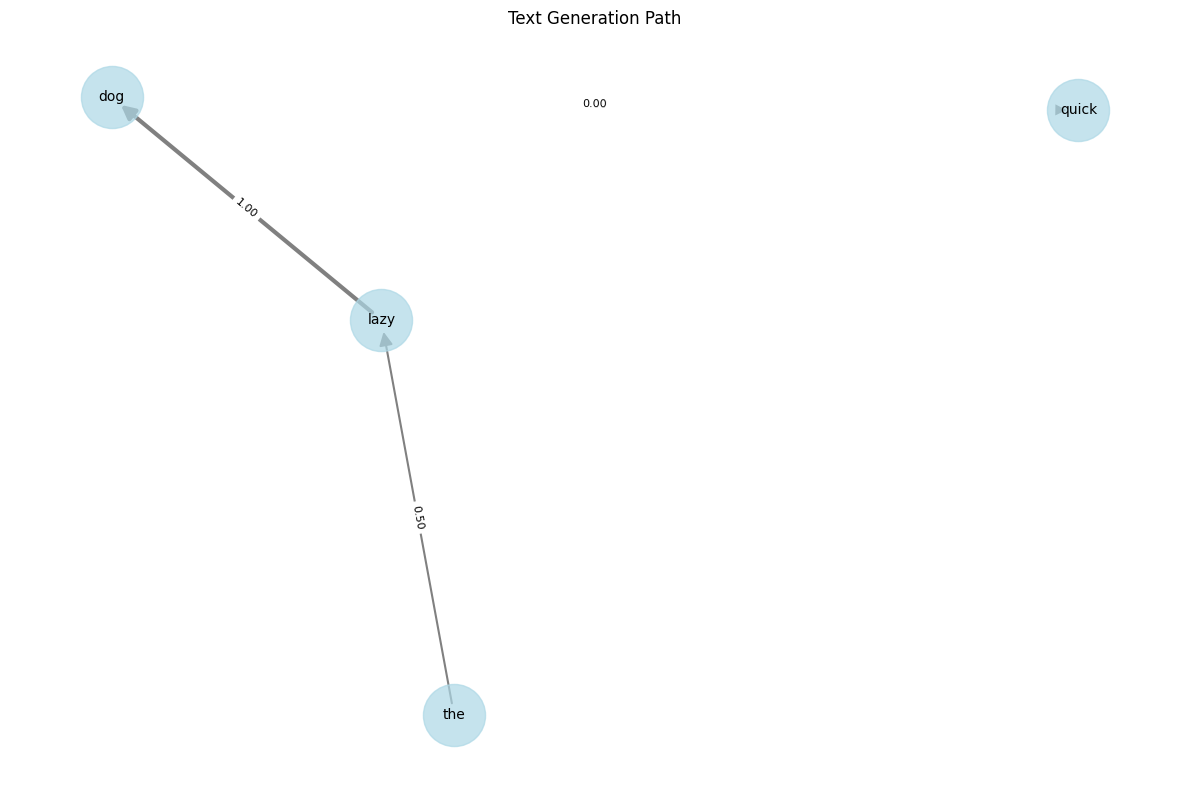

In [ ]:
generator.visualize_generation_path()

### Membangun Model Markov untuk Korpus Teks yang lebih besar

Dalam percobaan ini, kita akan memanfaatkan dua sumber data untuk mempelajari proses prediksi menggunakan Markov Chain dalam pengolahan teks:

* Dataset dari NLTK (Natural Language Toolkit):
nltk adalah pustaka populer dalam Python untuk pemrosesan bahasa alami. NLTK menyediakan berbagai dataset yang berguna, termasuk korpus teks, tokenisasi, dan stopwords untuk berbagai bahasa. Dataset dari nltk dapat digunakan untuk keperluan pemrosesan teks dasar, seperti menghapus tanda baca, menghilangkan stopwords, dan membangun model prediksi berbasis Markov Chain.

* Dataset brown :
Dataset yang digunakan adalah Brown Corpus. Brown Corpus adalah korpus teks pertama yang disusun dengan sistematis, terdiri dari sekitar 500 dokumen teks dengan lebih dari 1 juta kata. Korpus ini dikategorikan ke dalam 15 genre atau topik, seperti berita, fiksi, esai, dan sebagainya.


In [ ]:
!pip install datasets
!pip install nltk

In [ ]:
from datasets import load_dataset
import nltk
from nltk.corpus import brown
from nltk.tokenize import word_tokenize

# Pastikan NLTK resource untuk 'brown' dan 'punkt' sudah diunduh
nltk.download("brown")
nltk.download("punkt")

# Memuat dataset Brown dari NLTK
dataset = brown.sents()



[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:

# Menampilkan beberapa contoh kalimat dari Brown Corpus
print("Contoh kalimat dari Brown Corpus:")
for i in range(3):
    print(" ".join(dataset[i]))

# Tokenisasi kalimat pertama sebagai contoh
sample_sentence = " ".join(dataset[0])
tokens = word_tokenize(sample_sentence)

print("\nToken hasil tokenisasi:")
print(tokens)

Contoh kalimat dari Brown Corpus:
The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .
The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .
The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .

Token hasil tokenisasi:
['The', 'Fulton', 'County', 'Grand', 'Jury', 'said', 'Friday', 'an', 'investigation', 'of', 'Atlanta', "'s", 'recent', 'primary', 'election', 'produced', '``', 'no', 'evidence', '``', 'that', 'any', 'irregularities', 'took', 'place', '.']


Di sini kita akan melakukan uji coba menggunakan korpus teks bahasa Inggris

In [ ]:
English = [" ".join(sentence) for sentence in dataset]
len(English)

57340

In [ ]:
English[:10]

["The Fulton County Grand Jury said Friday an investigation of Atlanta's recent primary election produced `` no evidence '' that any irregularities took place .",
 "The jury further said in term-end presentments that the City Executive Committee , which had over-all charge of the election , `` deserves the praise and thanks of the City of Atlanta '' for the manner in which the election was conducted .",
 "The September-October term jury had been charged by Fulton Superior Court Judge Durwood Pye to investigate reports of possible `` irregularities '' in the hard-fought primary which was won by Mayor-nominate Ivan Allen Jr. .",
 "`` Only a relative handful of such reports was received '' , the jury said , `` considering the widespread interest in the election , the number of voters and the size of this city '' .",
 "The jury said it did find that many of Georgia's registration and election laws `` are outmoded or inadequate and often ambiguous '' .",
 "It recommended that Fulton legisla

In [ ]:
size = len(English)
size_sampling = int(1 * size)
size_sampling

57340

Tokenisasi

In [ ]:
englishGenerator = MarkovTextGenerator()
tokens = englishGenerator.tokenize(English)
print("Number of words:", len(tokens))

Number of words: 997541


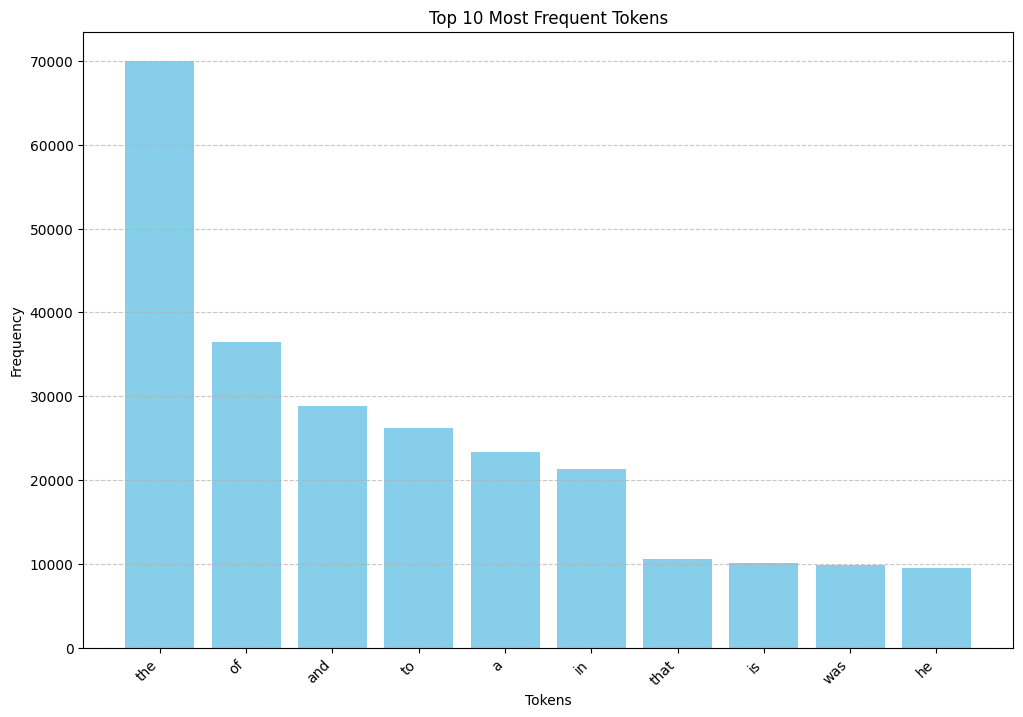

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_tokens(tokens, top_n=20):
    """
    Fungsi untuk memplot histogram frekuensi token.

    Parameters:
    -----------
    tokens : list
        Daftar token yang dihasilkan dari teks.
    top_n : int
        Jumlah token dengan frekuensi tertinggi yang akan ditampilkan.
    """
    # Hitung frekuensi token
    token_counts = Counter(tokens)

    # Ambil top_n token dengan frekuensi tertinggi
    most_common_tokens = token_counts.most_common(top_n)
    words, counts = zip(*most_common_tokens)

    # Plot histogram
    plt.figure(figsize=(12, 8))
    plt.bar(words, counts, color='skyblue')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Tokens')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Most Frequent Tokens')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


plot_tokens(tokens, top_n=10)


In [ ]:
# Build the model
englishGenerator.build_model(tokens)

In [ ]:
# Get vocabulary size
print("Vocabulary size:", len(englishGenerator.get_vocabulary()))

# Show first 10 words in vocabulary
print("Sample words:", list(englishGenerator.get_vocabulary())[:10])

Vocabulary size: 42027
Sample words: ['tiresome', 'impassable', 'hilar', 'preston', 'perfectionism', 'muddied', 'wolfishly', 'saturated', 'willed', 'freeing']


In [ ]:
text = englishGenerator.generate_text("rain", method="maximum", num_words=4)
text

'rain and the first'

In [ ]:

texts_df = englishGenerator.generate_multiple_texts(
    start_words=["the", "and", "of"],
    num_texts=6,
    methods=["random", "maximum", "weighted"],
    temperature=[0.5, 1.0, 2.0],
    return_format="df"
)
if isinstance(texts_df, pd.DataFrame):
    avg_length = texts_df.groupby('method')['text'].apply(
        lambda x: x.str.split().str.len().mean()
    )
    print("\nAverage text length by method:")
    print(avg_length)


Average text length by method:
method
maximum     20.0
random      20.0
weighted    20.0
Name: text, dtype: float64


In [ ]:
texts_df

,sample_id,start_word,method,temperature,text
0,1,the,random,0.5,the primary one of all shelley and since she w...
1,2,and,maximum,1.0,and the first time to the first time to the fi...
2,3,of,weighted,2.0,of orienting the aecs division of multiplicity...
3,4,the,random,0.5,the latter had been dead fly jim mcdaniel sing...
4,5,and,maximum,1.0,and the first time to the first time to the fi...
5,6,of,weighted,2.0,of rocks sloping terrain for shoals of protest...


Namun dari permodelan di atas kami menemukan dan mencoba menyelesaikan beberapa permasalahan :  
1. Kita tinjau bahwa nilai ukuran parameter n gram dapat berubah - rubah, kita tidak dapat menentukan ukuran n gram mana yang paling sesuai untuk model kita (bi-gram? tri-gram? uni-gram? )
2. Jumlah state yang optimal, bagaimana traversal state yang optimal, mungkin kita bisa mereduksi state sehingga menampilkan sub kata yang penting saja
3. Permasalahan random state, misalkan kita berada di $state_a$ diketahui bahwa P($state_b$ | $state_a$) == P($state_c$ | $state_a$), sejauh ini kita menggunakan random state, sehingga tidak bisa memastikan seberapa optimal pemilihan state tersebut, padahal belum tentu state berikutnya yang terhubung optimal pada hasil prediksi generasi teksnya.

Oleh karenanya atas dasar permasalahan penyesuaian parameter di atas, agar mendapatkan hasil generasi yang optimal kami melakukan uji coba dengan penerapan metode Algoritma Genetika yang akan dijelaskan oleh rekan saya pada bagian berikutnya :) monggo mas Faiz Rek


Evaluasi
* Berapa Kali Random generate sampe dapat hasil yang diharapkan
`given word = the`
`expected sentence = the quick brown fox (state = 4)`
hasil generate
- the lazy dog dog
- the lazy dog jumps
- the quick brown fox
Random Step = 3
* Perplexity
* Visualisai Graph : Random, Maximum, weighted with Temperature

In [ ]:
brown_words = " ".join(brown.words())
brownTMatrix = transitionMatrix(brown_words, 2)
brownGenerator = MarkovTextGenerator(brownTMatrix)

KeyboardInterrupt: 